In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (379/379), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 379 (delta 177), reused 300 (delta 101), pack-reused 0
Receiving objects: 100% (379/379), 45.61 MiB | 26.84 MiB/s, done.
Resolving deltas: 100% (177/177), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6288, done.
remote: Counting objects: 100% (790/790), done.
remote: Compressing objects: 100% (458/458), done.
remote: Total 6288 (delta 463), reused 508 (delta 325), pack-reused 5498
Receiving objects: 100% (6288/6288), 13.18 MiB | 23.18 MiB/s, done.
Resolving deltas: 100% (4495/4495), done.
/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.21.1


In [5]:
!rm -rf ToTrain/
!unzip ../../ToTrain.zip

Archive:  ../../ToTrain.zip
   creating: ToTrain/
   creating: ToTrain/annotations/
  inflating: ToTrain/annotations/image020-roi1.tif  
  inflating: ToTrain/annotations/image008-roi1.tif  
  inflating: ToTrain/annotations/image032-roi1.tif  
  inflating: ToTrain/annotations/image019-roi2.tif  
  inflating: ToTrain/annotations/image019-roi5.tif  
  inflating: ToTrain/annotations/image058-roi5.tif  
  inflating: ToTrain/annotations/image038-roi4.tif  
  inflating: ToTrain/annotations/image058-roi1.tif  
  inflating: ToTrain/annotations/image021-roi3.tif  
  inflating: ToTrain/annotations/image006-roi2.tif  
  inflating: ToTrain/annotations/image021-roi6.tif  
  inflating: ToTrain/annotations/image038-roi1.tif  
  inflating: ToTrain/annotations/image003-2-roi3.tif  
  inflating: ToTrain/annotations/image038-roi3.tif  
  inflating: ToTrain/annotations/image039-roi3.tif  
  inflating: ToTrain/annotations/image017-roi1.tif  
  inflating: ToTrain/annotations/image004-roi2.tif  
  inflating: 

In [6]:
data_root = 'ToTrain'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

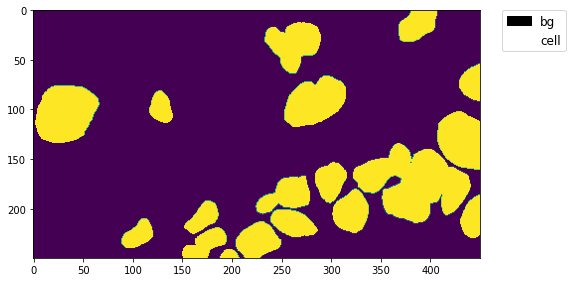

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('ToTrain/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.tif', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [16]:
cfg = Config.fromfile('../models/pspnet_unet.py')

In [17]:
cfg.runner.max_epochs = 50
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'ToTrain'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='Resize

In [18]:
datasets = [build_dataset(cfg.data.train)]

2022-02-27 15:57:59,470 - mmseg - INFO - Loaded 96 images


In [19]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [20]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-27 15:58:04,083 - mmseg - INFO - Loaded 24 images
2022-02-27 15:58:04,085 - mmseg - INFO - Start running, host: root@ba72e24fbdae, work_dir: /content/tcc/mmsegmentation/work_dirs/unet
2022-02-27 15:58:04,090 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 24.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:58:16,401 - mmseg - INFO - per class results:
2022-02-27 15:58:16,404 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.82 | 99.63 |
|  cell |  6.18 |  3.21 |
+-------+-------+-------+
2022-02-27 15:58:16,405 - mmseg - INFO - Summary:
2022-02-27 15:58:16,409 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 68.15 |  43.5 | 51.42 |
+-------+-------+-------+
2022-02-27 15:58:16,412 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6815, mDice: 0.4350, mAcc: 0.5142, Dice.bg: 0.8082, Dice.cell: 0.0618, Acc.bg: 0.9963, Acc.cell: 0.0321
2022-02-27 15:58:27,592 - mmseg - INFO - Epoch [2][12/12]	lr: 9.822e-03, eta: 0:08:33, time: 0.886, data_time: 0.191, memory: 5172, decode.loss_ce: 0.4636, decode.acc_seg: 72.2667, aux.loss_ce: 0.1940, aux.acc_seg: 70.1186, loss: 0.6576


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.8 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:58:28,406 - mmseg - INFO - per class results:
2022-02-27 15:58:28,408 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.87 | 98.12 |
|  cell | 40.01 | 25.98 |
+-------+-------+-------+
2022-02-27 15:58:28,409 - mmseg - INFO - Summary:
2022-02-27 15:58:28,412 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.57 | 61.94 | 62.05 |
+-------+-------+-------+
2022-02-27 15:58:28,420 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.7457, mDice: 0.6194, mAcc: 0.6205, Dice.bg: 0.8387, Dice.cell: 0.4001, Acc.bg: 0.9812, Acc.cell: 0.2598
2022-02-27 15:58:39,465 - mmseg - INFO - Epoch [3][12/12]	lr: 9.643e-03, eta: 0:08:19, time: 0.875, data_time: 0.179, memory: 5172, decode.loss_ce: 0.3855, decode.acc_seg: 74.7131, aux.loss_ce: 0.1665, aux.acc_seg: 71.4787, loss: 0.5520


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.2 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:58:40,296 - mmseg - INFO - per class results:
2022-02-27 15:58:40,298 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.95 |  95.0 |
|  cell | 59.03 | 46.19 |
+-------+-------+-------+
2022-02-27 15:58:40,299 - mmseg - INFO - Summary:
2022-02-27 15:58:40,302 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 79.07 | 72.49 | 70.6 |
+-------+-------+------+
2022-02-27 15:58:40,307 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7907, mDice: 0.7249, mAcc: 0.7060, Dice.bg: 0.8595, Dice.cell: 0.5903, Acc.bg: 0.9500, Acc.cell: 0.4619
2022-02-27 15:58:51,513 - mmseg - INFO - Epoch [4][12/12]	lr: 9.464e-03, eta: 0:08:09, time: 0.887, data_time: 0.186, memory: 5172, decode.loss_ce: 0.3874, decode.acc_seg: 77.4656, aux.loss_ce: 0.1688, aux.acc_seg: 73.7905, loss: 0.5563


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.1 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:58:52,347 - mmseg - INFO - per class results:
2022-02-27 15:58:52,349 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.18 | 93.88 |
|  cell | 61.91 |  50.5 |
+-------+-------+-------+
2022-02-27 15:58:52,350 - mmseg - INFO - Summary:
2022-02-27 15:58:52,355 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.72 | 74.04 | 72.19 |
+-------+-------+-------+
2022-02-27 15:58:52,356 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7972, mDice: 0.7404, mAcc: 0.7219, Dice.bg: 0.8618, Dice.cell: 0.6191, Acc.bg: 0.9388, Acc.cell: 0.5050
2022-02-27 15:59:03,679 - mmseg - INFO - Epoch [5][12/12]	lr: 9.284e-03, eta: 0:07:59, time: 0.897, data_time: 0.193, memory: 5172, decode.loss_ce: 0.3826, decode.acc_seg: 77.8719, aux.loss_ce: 0.1685, aux.acc_seg: 74.1995, loss: 0.5510


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:59:04,490 - mmseg - INFO - per class results:
2022-02-27 15:59:04,491 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.91 | 87.15 |
|  cell | 69.61 | 67.54 |
+-------+-------+-------+
2022-02-27 15:59:04,494 - mmseg - INFO - Summary:
2022-02-27 15:59:04,500 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.75 | 77.76 | 77.35 |
+-------+-------+-------+
2022-02-27 15:59:04,501 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.8075, mDice: 0.7776, mAcc: 0.7735, Dice.bg: 0.8591, Dice.cell: 0.6961, Acc.bg: 0.8715, Acc.cell: 0.6754
2022-02-27 15:59:15,839 - mmseg - INFO - Epoch [6][12/12]	lr: 9.104e-03, eta: 0:07:49, time: 0.898, data_time: 0.192, memory: 5172, decode.loss_ce: 0.3486, decode.acc_seg: 78.8804, aux.loss_ce: 0.1519, aux.acc_seg: 76.3097, loss: 0.5005


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.1 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:59:16,674 - mmseg - INFO - per class results:
2022-02-27 15:59:16,676 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.87 | 86.14 |
|  cell | 70.55 | 70.09 |
+-------+-------+-------+
2022-02-27 15:59:16,678 - mmseg - INFO - Summary:
2022-02-27 15:59:16,683 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.9 | 78.21 | 78.11 |
+------+-------+-------+
2022-02-27 15:59:16,686 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.8090, mDice: 0.7821, mAcc: 0.7811, Dice.bg: 0.8587, Dice.cell: 0.7055, Acc.bg: 0.8614, Acc.cell: 0.7009
2022-02-27 15:59:27,998 - mmseg - INFO - Epoch [7][12/12]	lr: 8.924e-03, eta: 0:07:39, time: 0.896, data_time: 0.185, memory: 5172, decode.loss_ce: 0.3763, decode.acc_seg: 79.4745, aux.loss_ce: 0.1578, aux.acc_seg: 78.1000, loss: 0.5341


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.8 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:59:28,844 - mmseg - INFO - per class results:
2022-02-27 15:59:28,846 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.8 | 84.52 |
|  cell | 72.01 | 74.23 |
+-------+-------+-------+
2022-02-27 15:59:28,851 - mmseg - INFO - Summary:
2022-02-27 15:59:28,852 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.16 | 78.91 | 79.38 |
+-------+-------+-------+
2022-02-27 15:59:28,857 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.8116, mDice: 0.7891, mAcc: 0.7938, Dice.bg: 0.8580, Dice.cell: 0.7201, Acc.bg: 0.8452, Acc.cell: 0.7423
2022-02-27 15:59:40,147 - mmseg - INFO - Epoch [8][12/12]	lr: 8.743e-03, eta: 0:07:29, time: 0.894, data_time: 0.184, memory: 5172, decode.loss_ce: 0.3337, decode.acc_seg: 79.8288, aux.loss_ce: 0.1428, aux.acc_seg: 77.8175, loss: 0.4765


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:59:40,985 - mmseg - INFO - per class results:
2022-02-27 15:59:40,987 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.96 | 84.28 |
|  cell | 72.71 | 75.65 |
+-------+-------+-------+
2022-02-27 15:59:40,988 - mmseg - INFO - Summary:
2022-02-27 15:59:40,991 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.46 | 79.34 | 79.97 |
+-------+-------+-------+
2022-02-27 15:59:40,998 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.8146, mDice: 0.7934, mAcc: 0.7997, Dice.bg: 0.8596, Dice.cell: 0.7271, Acc.bg: 0.8428, Acc.cell: 0.7565
2022-02-27 15:59:52,339 - mmseg - INFO - Epoch [9][12/12]	lr: 8.562e-03, eta: 0:07:18, time: 0.898, data_time: 0.185, memory: 5172, decode.loss_ce: 0.3330, decode.acc_seg: 80.7940, aux.loss_ce: 0.1419, aux.acc_seg: 79.1571, loss: 0.4748


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 15:59:53,193 - mmseg - INFO - per class results:
2022-02-27 15:59:53,195 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.88 | 87.25 |
|  cell | 72.57 | 71.93 |
+-------+-------+-------+
2022-02-27 15:59:53,199 - mmseg - INFO - Summary:
2022-02-27 15:59:53,202 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.25 | 79.73 | 79.59 |
+-------+-------+-------+
2022-02-27 15:59:53,207 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.8225, mDice: 0.7973, mAcc: 0.7959, Dice.bg: 0.8688, Dice.cell: 0.7257, Acc.bg: 0.8725, Acc.cell: 0.7193
2022-02-27 16:00:04,654 - mmseg - INFO - Epoch [10][12/12]	lr: 8.381e-03, eta: 0:07:08, time: 0.907, data_time: 0.192, memory: 5172, decode.loss_ce: 0.3261, decode.acc_seg: 80.7692, aux.loss_ce: 0.1358, aux.acc_seg: 79.5240, loss: 0.4619
2022-02-27 16:00:04,656 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:00:06,701 - mmseg - INFO - per class results:
2022-02-27 16:00:06,704 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.1 | 85.94 |
|  cell | 74.44 | 76.48 |
+-------+-------+-------+
2022-02-27 16:00:06,705 - mmseg - INFO - Summary:
2022-02-27 16:00:06,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.85 | 80.77 | 81.21 |
+-------+-------+-------+
2022-02-27 16:00:06,712 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.8285, mDice: 0.8077, mAcc: 0.8121, Dice.bg: 0.8710, Dice.cell: 0.7444, Acc.bg: 0.8594, Acc.cell: 0.7648
2022-02-27 16:00:18,163 - mmseg - INFO - Epoch [11][12/12]	lr: 8.199e-03, eta: 0:06:58, time: 0.908, data_time: 0.189, memory: 5172, decode.loss_ce: 0.3206, decode.acc_seg: 80.9656, aux.loss_ce: 0.1368, aux.acc_seg: 79.4445, loss: 0.4574


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:00:19,004 - mmseg - INFO - per class results:
2022-02-27 16:00:19,006 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.08 | 86.08 |
|  cell | 74.24 | 75.99 |
+-------+-------+-------+
2022-02-27 16:00:19,011 - mmseg - INFO - Summary:
2022-02-27 16:00:19,012 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.79 | 80.66 | 81.04 |
+-------+-------+-------+
2022-02-27 16:00:19,017 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.8279, mDice: 0.8066, mAcc: 0.8104, Dice.bg: 0.8708, Dice.cell: 0.7424, Acc.bg: 0.8608, Acc.cell: 0.7599
2022-02-27 16:00:30,434 - mmseg - INFO - Epoch [12][12/12]	lr: 8.016e-03, eta: 0:06:48, time: 0.904, data_time: 0.182, memory: 5172, decode.loss_ce: 0.3399, decode.acc_seg: 81.5586, aux.loss_ce: 0.1449, aux.acc_seg: 79.9948, loss: 0.4849


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:00:31,260 - mmseg - INFO - per class results:
2022-02-27 16:00:31,261 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.99 | 85.87 |
|  cell | 74.18 | 76.15 |
+-------+-------+-------+
2022-02-27 16:00:31,262 - mmseg - INFO - Summary:
2022-02-27 16:00:31,270 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.7 | 80.58 | 81.01 |
+------+-------+-------+
2022-02-27 16:00:31,272 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.8270, mDice: 0.8058, mAcc: 0.8101, Dice.bg: 0.8699, Dice.cell: 0.7418, Acc.bg: 0.8587, Acc.cell: 0.7615
2022-02-27 16:00:42,790 - mmseg - INFO - Epoch [13][12/12]	lr: 7.833e-03, eta: 0:06:38, time: 0.912, data_time: 0.190, memory: 5172, decode.loss_ce: 0.3262, decode.acc_seg: 81.9331, aux.loss_ce: 0.1346, aux.acc_seg: 80.9132, loss: 0.4608


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:00:43,629 - mmseg - INFO - per class results:
2022-02-27 16:00:43,630 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.99 | 85.69 |
|  cell | 74.36 | 76.66 |
+-------+-------+-------+
2022-02-27 16:00:43,631 - mmseg - INFO - Summary:
2022-02-27 16:00:43,633 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.74 | 80.68 | 81.17 |
+-------+-------+-------+
2022-02-27 16:00:43,637 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.8274, mDice: 0.8068, mAcc: 0.8117, Dice.bg: 0.8699, Dice.cell: 0.7436, Acc.bg: 0.8569, Acc.cell: 0.7666
2022-02-27 16:00:55,041 - mmseg - INFO - Epoch [14][12/12]	lr: 7.650e-03, eta: 0:06:27, time: 0.902, data_time: 0.177, memory: 5172, decode.loss_ce: 0.3252, decode.acc_seg: 81.8586, aux.loss_ce: 0.1382, aux.acc_seg: 80.3660, loss: 0.4633


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:00:55,891 - mmseg - INFO - per class results:
2022-02-27 16:00:55,893 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.41 | 86.72 |
|  cell | 74.64 | 75.86 |
+-------+-------+-------+
2022-02-27 16:00:55,894 - mmseg - INFO - Summary:
2022-02-27 16:00:55,896 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.17 | 81.03 | 81.29 |
+-------+-------+-------+
2022-02-27 16:00:55,900 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.8317, mDice: 0.8103, mAcc: 0.8129, Dice.bg: 0.8741, Dice.cell: 0.7464, Acc.bg: 0.8672, Acc.cell: 0.7586
2022-02-27 16:01:07,423 - mmseg - INFO - Epoch [15][12/12]	lr: 7.466e-03, eta: 0:06:17, time: 0.913, data_time: 0.185, memory: 5172, decode.loss_ce: 0.3105, decode.acc_seg: 81.9116, aux.loss_ce: 0.1309, aux.acc_seg: 80.5268, loss: 0.4414


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.6 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:01:08,272 - mmseg - INFO - per class results:
2022-02-27 16:01:08,273 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.52 | 84.32 |
|  cell | 74.26 | 78.17 |
+-------+-------+-------+
2022-02-27 16:01:08,274 - mmseg - INFO - Summary:
2022-02-27 16:01:08,277 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.31 | 80.39 | 81.24 |
+-------+-------+-------+
2022-02-27 16:01:08,281 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.8231, mDice: 0.8039, mAcc: 0.8124, Dice.bg: 0.8652, Dice.cell: 0.7426, Acc.bg: 0.8432, Acc.cell: 0.7817
2022-02-27 16:01:19,841 - mmseg - INFO - Epoch [16][12/12]	lr: 7.282e-03, eta: 0:06:06, time: 0.916, data_time: 0.189, memory: 5172, decode.loss_ce: 0.3168, decode.acc_seg: 81.7855, aux.loss_ce: 0.1305, aux.acc_seg: 81.1929, loss: 0.4473


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.1 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:01:20,703 - mmseg - INFO - per class results:
2022-02-27 16:01:20,705 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.73 | 87.52 |
|  cell | 74.86 | 75.24 |
+-------+-------+-------+
2022-02-27 16:01:20,711 - mmseg - INFO - Summary:
2022-02-27 16:01:20,712 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.51 |  81.3 | 81.38 |
+-------+-------+-------+
2022-02-27 16:01:20,715 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.8351, mDice: 0.8130, mAcc: 0.8138, Dice.bg: 0.8773, Dice.cell: 0.7486, Acc.bg: 0.8752, Acc.cell: 0.7524
2022-02-27 16:01:32,325 - mmseg - INFO - Epoch [17][12/12]	lr: 7.097e-03, eta: 0:05:56, time: 0.919, data_time: 0.191, memory: 5172, decode.loss_ce: 0.3077, decode.acc_seg: 82.6592, aux.loss_ce: 0.1288, aux.acc_seg: 81.5307, loss: 0.4365


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:01:33,178 - mmseg - INFO - per class results:
2022-02-27 16:01:33,180 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.81 | 87.68 |
|  cell | 74.95 | 75.17 |
+-------+-------+-------+
2022-02-27 16:01:33,187 - mmseg - INFO - Summary:
2022-02-27 16:01:33,189 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.6 | 81.38 | 81.43 |
+------+-------+-------+
2022-02-27 16:01:33,190 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.8360, mDice: 0.8138, mAcc: 0.8143, Dice.bg: 0.8781, Dice.cell: 0.7495, Acc.bg: 0.8768, Acc.cell: 0.7517
2022-02-27 16:01:44,783 - mmseg - INFO - Epoch [18][12/12]	lr: 6.911e-03, eta: 0:05:46, time: 0.918, data_time: 0.189, memory: 5172, decode.loss_ce: 0.3120, decode.acc_seg: 81.9237, aux.loss_ce: 0.1291, aux.acc_seg: 80.6933, loss: 0.4411


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:01:45,619 - mmseg - INFO - per class results:
2022-02-27 16:01:45,621 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.57 |  85.5 |
|  cell | 73.32 | 75.19 |
+-------+-------+-------+
2022-02-27 16:01:45,622 - mmseg - INFO - Summary:
2022-02-27 16:01:45,624 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.13 | 79.94 | 80.34 |
+-------+-------+-------+
2022-02-27 16:01:45,629 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.8213, mDice: 0.7994, mAcc: 0.8034, Dice.bg: 0.8657, Dice.cell: 0.7332, Acc.bg: 0.8550, Acc.cell: 0.7519
2022-02-27 16:01:57,244 - mmseg - INFO - Epoch [19][12/12]	lr: 6.725e-03, eta: 0:05:35, time: 0.920, data_time: 0.186, memory: 5172, decode.loss_ce: 0.3062, decode.acc_seg: 82.3357, aux.loss_ce: 0.1258, aux.acc_seg: 81.7613, loss: 0.4320


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:01:58,095 - mmseg - INFO - per class results:
2022-02-27 16:01:58,097 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.18 |  90.0 |
|  cell |  74.0 | 70.84 |
+-------+-------+-------+
2022-02-27 16:01:58,098 - mmseg - INFO - Summary:
2022-02-27 16:01:58,101 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.75 | 81.09 | 80.42 |
+-------+-------+-------+
2022-02-27 16:01:58,105 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.8375, mDice: 0.8109, mAcc: 0.8042, Dice.bg: 0.8818, Dice.cell: 0.7400, Acc.bg: 0.9000, Acc.cell: 0.7084
2022-02-27 16:02:09,741 - mmseg - INFO - Epoch [20][12/12]	lr: 6.539e-03, eta: 0:05:25, time: 0.921, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3317, decode.acc_seg: 81.3244, aux.loss_ce: 0.1359, aux.acc_seg: 80.6893, loss: 0.4676
2022-02-27 16:02:09,743 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:02:11,630 - mmseg - INFO - per class results:
2022-02-27 16:02:11,633 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.63 | 83.99 |
|  cell | 74.83 | 79.53 |
+-------+-------+-------+
2022-02-27 16:02:11,634 - mmseg - INFO - Summary:
2022-02-27 16:02:11,637 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.54 | 80.73 | 81.76 |
+-------+-------+-------+
2022-02-27 16:02:11,641 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.8254, mDice: 0.8073, mAcc: 0.8176, Dice.bg: 0.8663, Dice.cell: 0.7483, Acc.bg: 0.8399, Acc.cell: 0.7953
2022-02-27 16:02:23,269 - mmseg - INFO - Epoch [21][12/12]	lr: 6.351e-03, eta: 0:05:14, time: 0.920, data_time: 0.187, memory: 5172, decode.loss_ce: 0.3132, decode.acc_seg: 81.8342, aux.loss_ce: 0.1295, aux.acc_seg: 80.9363, loss: 0.4428


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:02:24,136 - mmseg - INFO - per class results:
2022-02-27 16:02:24,138 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.54 | 86.71 |
|  cell | 75.01 | 76.46 |
+-------+-------+-------+
2022-02-27 16:02:24,139 - mmseg - INFO - Summary:
2022-02-27 16:02:24,141 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.37 | 81.27 | 81.59 |
+-------+-------+-------+
2022-02-27 16:02:24,142 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.8337, mDice: 0.8127, mAcc: 0.8159, Dice.bg: 0.8754, Dice.cell: 0.7501, Acc.bg: 0.8671, Acc.cell: 0.7646
2022-02-27 16:02:35,801 - mmseg - INFO - Epoch [22][12/12]	lr: 6.163e-03, eta: 0:05:04, time: 0.923, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3082, decode.acc_seg: 82.0966, aux.loss_ce: 0.1264, aux.acc_seg: 81.3068, loss: 0.4345


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:02:36,654 - mmseg - INFO - per class results:
2022-02-27 16:02:36,656 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.83 | 87.99 |
|  cell | 74.73 | 74.44 |
+-------+-------+-------+
2022-02-27 16:02:36,657 - mmseg - INFO - Summary:
2022-02-27 16:02:36,659 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.57 | 81.28 | 81.21 |
+-------+-------+-------+
2022-02-27 16:02:36,662 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.8357, mDice: 0.8128, mAcc: 0.8121, Dice.bg: 0.8783, Dice.cell: 0.7473, Acc.bg: 0.8799, Acc.cell: 0.7444
2022-02-27 16:02:48,406 - mmseg - INFO - Epoch [23][12/12]	lr: 5.975e-03, eta: 0:04:53, time: 0.930, data_time: 0.193, memory: 5172, decode.loss_ce: 0.3379, decode.acc_seg: 82.0144, aux.loss_ce: 0.1370, aux.acc_seg: 81.1744, loss: 0.4749


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:02:49,272 - mmseg - INFO - per class results:
2022-02-27 16:02:49,274 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.96 |  85.1 |
|  cell | 74.78 | 78.07 |
+-------+-------+-------+
2022-02-27 16:02:49,275 - mmseg - INFO - Summary:
2022-02-27 16:02:49,277 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.81 | 80.87 | 81.59 |
+-------+-------+-------+
2022-02-27 16:02:49,286 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.8281, mDice: 0.8087, mAcc: 0.8159, Dice.bg: 0.8696, Dice.cell: 0.7478, Acc.bg: 0.8510, Acc.cell: 0.7807
2022-02-27 16:03:00,911 - mmseg - INFO - Epoch [24][12/12]	lr: 5.786e-03, eta: 0:04:42, time: 0.920, data_time: 0.184, memory: 5172, decode.loss_ce: 0.3080, decode.acc_seg: 81.7692, aux.loss_ce: 0.1267, aux.acc_seg: 81.2036, loss: 0.4347


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.8 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:03:01,753 - mmseg - INFO - per class results:
2022-02-27 16:03:01,754 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.05 | 89.48 |
|  cell | 74.08 |  71.6 |
+-------+-------+-------+
2022-02-27 16:03:01,755 - mmseg - INFO - Summary:
2022-02-27 16:03:01,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.64 | 81.06 | 80.54 |
+-------+-------+-------+
2022-02-27 16:03:01,763 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.8364, mDice: 0.8106, mAcc: 0.8054, Dice.bg: 0.8805, Dice.cell: 0.7408, Acc.bg: 0.8948, Acc.cell: 0.7160
2022-02-27 16:03:13,485 - mmseg - INFO - Epoch [25][12/12]	lr: 5.596e-03, eta: 0:04:32, time: 0.928, data_time: 0.191, memory: 5172, decode.loss_ce: 0.2964, decode.acc_seg: 83.0111, aux.loss_ce: 0.1214, aux.acc_seg: 82.4996, loss: 0.4179


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.5 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:03:14,337 - mmseg - INFO - per class results:
2022-02-27 16:03:14,338 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.51 | 87.43 |
|  cell | 74.29 | 74.42 |
+-------+-------+-------+
2022-02-27 16:03:14,341 - mmseg - INFO - Summary:
2022-02-27 16:03:14,346 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.18 |  80.9 | 80.92 |
+-------+-------+-------+
2022-02-27 16:03:14,351 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8318, mDice: 0.8090, mAcc: 0.8092, Dice.bg: 0.8751, Dice.cell: 0.7429, Acc.bg: 0.8743, Acc.cell: 0.7442
2022-02-27 16:03:26,093 - mmseg - INFO - Epoch [26][12/12]	lr: 5.405e-03, eta: 0:04:21, time: 0.930, data_time: 0.190, memory: 5172, decode.loss_ce: 0.3193, decode.acc_seg: 83.1141, aux.loss_ce: 0.1290, aux.acc_seg: 82.4625, loss: 0.4483


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:03:26,951 - mmseg - INFO - per class results:
2022-02-27 16:03:26,952 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.16 | 88.62 |
|  cell | 75.18 | 74.37 |
+-------+-------+-------+
2022-02-27 16:03:26,954 - mmseg - INFO - Summary:
2022-02-27 16:03:26,959 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.97 | 81.67 | 81.49 |
+-------+-------+-------+
2022-02-27 16:03:26,961 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8397, mDice: 0.8167, mAcc: 0.8149, Dice.bg: 0.8816, Dice.cell: 0.7518, Acc.bg: 0.8862, Acc.cell: 0.7437
2022-02-27 16:03:38,719 - mmseg - INFO - Epoch [27][12/12]	lr: 5.214e-03, eta: 0:04:10, time: 0.931, data_time: 0.190, memory: 5172, decode.loss_ce: 0.3143, decode.acc_seg: 81.8041, aux.loss_ce: 0.1273, aux.acc_seg: 81.5366, loss: 0.4416


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 29.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:03:39,557 - mmseg - INFO - per class results:
2022-02-27 16:03:39,559 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.81 | 87.16 |
|  cell |  75.4 | 76.54 |
+-------+-------+-------+
2022-02-27 16:03:39,560 - mmseg - INFO - Summary:
2022-02-27 16:03:39,563 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.69 |  81.6 | 81.85 |
+-------+-------+-------+
2022-02-27 16:03:39,567 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8369, mDice: 0.8160, mAcc: 0.8185, Dice.bg: 0.8781, Dice.cell: 0.7540, Acc.bg: 0.8716, Acc.cell: 0.7654
2022-02-27 16:03:51,343 - mmseg - INFO - Epoch [28][12/12]	lr: 5.022e-03, eta: 0:04:00, time: 0.933, data_time: 0.192, memory: 5172, decode.loss_ce: 0.2953, decode.acc_seg: 82.8124, aux.loss_ce: 0.1204, aux.acc_seg: 82.1914, loss: 0.4157


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.7 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:03:52,219 - mmseg - INFO - per class results:
2022-02-27 16:03:52,222 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.52 | 85.96 |
|  cell | 75.62 | 78.41 |
+-------+-------+-------+
2022-02-27 16:03:52,223 - mmseg - INFO - Summary:
2022-02-27 16:03:52,225 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.49 | 81.57 | 82.18 |
+-------+-------+-------+
2022-02-27 16:03:52,230 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.8349, mDice: 0.8157, mAcc: 0.8218, Dice.bg: 0.8752, Dice.cell: 0.7562, Acc.bg: 0.8596, Acc.cell: 0.7841
2022-02-27 16:04:03,866 - mmseg - INFO - Epoch [29][12/12]	lr: 4.829e-03, eta: 0:03:49, time: 0.921, data_time: 0.178, memory: 5172, decode.loss_ce: 0.3169, decode.acc_seg: 82.5498, aux.loss_ce: 0.1296, aux.acc_seg: 82.0520, loss: 0.4465


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:04:04,725 - mmseg - INFO - per class results:
2022-02-27 16:04:04,728 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.73 | 87.43 |
|  cell | 74.95 | 75.49 |
+-------+-------+-------+
2022-02-27 16:04:04,729 - mmseg - INFO - Summary:
2022-02-27 16:04:04,731 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.53 | 81.34 | 81.46 |
+-------+-------+-------+
2022-02-27 16:04:04,736 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.8353, mDice: 0.8134, mAcc: 0.8146, Dice.bg: 0.8773, Dice.cell: 0.7495, Acc.bg: 0.8743, Acc.cell: 0.7549
2022-02-27 16:04:16,492 - mmseg - INFO - Epoch [30][12/12]	lr: 4.635e-03, eta: 0:03:38, time: 0.931, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3088, decode.acc_seg: 83.3451, aux.loss_ce: 0.1276, aux.acc_seg: 82.6730, loss: 0.4364
2022-02-27 16:04:16,495 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.7 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:04:18,379 - mmseg - INFO - per class results:
2022-02-27 16:04:18,381 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.33 | 88.79 |
|  cell | 75.54 | 74.74 |
+-------+-------+-------+
2022-02-27 16:04:18,383 - mmseg - INFO - Summary:
2022-02-27 16:04:18,384 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 84.2 | 81.93 | 81.76 |
+------+-------+-------+
2022-02-27 16:04:18,386 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.8420, mDice: 0.8193, mAcc: 0.8176, Dice.bg: 0.8833, Dice.cell: 0.7554, Acc.bg: 0.8879, Acc.cell: 0.7474
2022-02-27 16:04:30,142 - mmseg - INFO - Epoch [31][12/12]	lr: 4.440e-03, eta: 0:03:27, time: 0.931, data_time: 0.189, memory: 5172, decode.loss_ce: 0.2959, decode.acc_seg: 83.2967, aux.loss_ce: 0.1210, aux.acc_seg: 82.6984, loss: 0.4169


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.1 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:04:31,005 - mmseg - INFO - per class results:
2022-02-27 16:04:31,006 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.15 | 87.53 |
|  cell | 76.07 | 77.17 |
+-------+-------+-------+
2022-02-27 16:04:31,007 - mmseg - INFO - Summary:
2022-02-27 16:04:31,010 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.15 | 82.11 | 82.35 |
+-------+-------+-------+
2022-02-27 16:04:31,018 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.8415, mDice: 0.8211, mAcc: 0.8235, Dice.bg: 0.8815, Dice.cell: 0.7607, Acc.bg: 0.8753, Acc.cell: 0.7717
2022-02-27 16:04:42,776 - mmseg - INFO - Epoch [32][12/12]	lr: 4.244e-03, eta: 0:03:17, time: 0.931, data_time: 0.188, memory: 5172, decode.loss_ce: 0.3020, decode.acc_seg: 82.9102, aux.loss_ce: 0.1237, aux.acc_seg: 82.4256, loss: 0.4256


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:04:43,643 - mmseg - INFO - per class results:
2022-02-27 16:04:43,646 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.67 | 86.48 |
|  cell | 75.59 | 77.71 |
+-------+-------+-------+
2022-02-27 16:04:43,647 - mmseg - INFO - Summary:
2022-02-27 16:04:43,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.61 | 81.63 | 82.09 |
+-------+-------+-------+
2022-02-27 16:04:43,653 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8361, mDice: 0.8163, mAcc: 0.8209, Dice.bg: 0.8767, Dice.cell: 0.7559, Acc.bg: 0.8648, Acc.cell: 0.7771
2022-02-27 16:04:55,403 - mmseg - INFO - Epoch [33][12/12]	lr: 4.047e-03, eta: 0:03:06, time: 0.930, data_time: 0.189, memory: 5172, decode.loss_ce: 0.3170, decode.acc_seg: 82.4599, aux.loss_ce: 0.1279, aux.acc_seg: 82.0983, loss: 0.4449


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:04:56,270 - mmseg - INFO - per class results:
2022-02-27 16:04:56,273 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.16 | 87.48 |
|  cell | 76.14 | 77.36 |
+-------+-------+-------+
2022-02-27 16:04:56,274 - mmseg - INFO - Summary:
2022-02-27 16:04:56,277 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.17 | 82.15 | 82.42 |
+-------+-------+-------+
2022-02-27 16:04:56,284 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.8417, mDice: 0.8215, mAcc: 0.8242, Dice.bg: 0.8816, Dice.cell: 0.7614, Acc.bg: 0.8748, Acc.cell: 0.7736
2022-02-27 16:05:08,036 - mmseg - INFO - Epoch [34][12/12]	lr: 3.849e-03, eta: 0:02:55, time: 0.931, data_time: 0.188, memory: 5172, decode.loss_ce: 0.2942, decode.acc_seg: 82.8273, aux.loss_ce: 0.1189, aux.acc_seg: 82.6929, loss: 0.4131


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.8 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:05:08,939 - mmseg - INFO - per class results:
2022-02-27 16:05:08,942 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.08 | 87.62 |
|  cell |  75.8 | 76.62 |
+-------+-------+-------+
2022-02-27 16:05:08,944 - mmseg - INFO - Summary:
2022-02-27 16:05:08,952 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.03 | 81.94 | 82.12 |
+-------+-------+-------+
2022-02-27 16:05:08,953 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8403, mDice: 0.8194, mAcc: 0.8212, Dice.bg: 0.8808, Dice.cell: 0.7580, Acc.bg: 0.8762, Acc.cell: 0.7662
2022-02-27 16:05:20,756 - mmseg - INFO - Epoch [35][12/12]	lr: 3.650e-03, eta: 0:02:44, time: 0.934, data_time: 0.188, memory: 5172, decode.loss_ce: 0.2979, decode.acc_seg: 83.4365, aux.loss_ce: 0.1228, aux.acc_seg: 82.7373, loss: 0.4206


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 21.2 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:05:21,900 - mmseg - INFO - per class results:
2022-02-27 16:05:21,928 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.0 | 87.31 |
|  cell | 75.84 | 77.08 |
+-------+-------+-------+
2022-02-27 16:05:21,932 - mmseg - INFO - Summary:
2022-02-27 16:05:21,938 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.97 | 81.92 | 82.19 |
+-------+-------+-------+
2022-02-27 16:05:21,943 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.8397, mDice: 0.8192, mAcc: 0.8219, Dice.bg: 0.8800, Dice.cell: 0.7584, Acc.bg: 0.8731, Acc.cell: 0.7708
2022-02-27 16:05:33,905 - mmseg - INFO - Epoch [36][12/12]	lr: 3.450e-03, eta: 0:02:33, time: 0.947, data_time: 0.202, memory: 5172, decode.loss_ce: 0.2826, decode.acc_seg: 83.3429, aux.loss_ce: 0.1154, aux.acc_seg: 82.7442, loss: 0.3980


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.2 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:05:34,767 - mmseg - INFO - per class results:
2022-02-27 16:05:34,769 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.18 | 87.54 |
|  cell | 76.14 | 77.28 |
+-------+-------+-------+
2022-02-27 16:05:34,771 - mmseg - INFO - Summary:
2022-02-27 16:05:34,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.19 | 82.16 | 82.41 |
+-------+-------+-------+
2022-02-27 16:05:34,780 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8419, mDice: 0.8216, mAcc: 0.8241, Dice.bg: 0.8818, Dice.cell: 0.7614, Acc.bg: 0.8754, Acc.cell: 0.7728
2022-02-27 16:05:46,628 - mmseg - INFO - Epoch [37][12/12]	lr: 3.248e-03, eta: 0:02:22, time: 0.938, data_time: 0.193, memory: 5172, decode.loss_ce: 0.2957, decode.acc_seg: 83.3334, aux.loss_ce: 0.1218, aux.acc_seg: 82.4987, loss: 0.4175


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:05:47,485 - mmseg - INFO - per class results:
2022-02-27 16:05:47,486 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.19 |  87.5 |
|  cell |  76.2 | 77.42 |
+-------+-------+-------+
2022-02-27 16:05:47,488 - mmseg - INFO - Summary:
2022-02-27 16:05:47,494 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.21 |  82.2 | 82.46 |
+-------+-------+-------+
2022-02-27 16:05:47,497 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8421, mDice: 0.8220, mAcc: 0.8246, Dice.bg: 0.8819, Dice.cell: 0.7620, Acc.bg: 0.8750, Acc.cell: 0.7742
2022-02-27 16:05:59,268 - mmseg - INFO - Epoch [38][12/12]	lr: 3.045e-03, eta: 0:02:11, time: 0.932, data_time: 0.187, memory: 5172, decode.loss_ce: 0.2936, decode.acc_seg: 83.4249, aux.loss_ce: 0.1198, aux.acc_seg: 82.8212, loss: 0.4133


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:06:00,125 - mmseg - INFO - per class results:
2022-02-27 16:06:00,127 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.0 | 86.94 |
|  cell | 76.13 | 78.03 |
+-------+-------+-------+
2022-02-27 16:06:00,128 - mmseg - INFO - Summary:
2022-02-27 16:06:00,131 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.03 | 82.06 | 82.48 |
+-------+-------+-------+
2022-02-27 16:06:00,134 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.8403, mDice: 0.8206, mAcc: 0.8248, Dice.bg: 0.8800, Dice.cell: 0.7613, Acc.bg: 0.8694, Acc.cell: 0.7803
2022-02-27 16:06:12,068 - mmseg - INFO - Epoch [39][12/12]	lr: 2.840e-03, eta: 0:02:01, time: 0.946, data_time: 0.199, memory: 5172, decode.loss_ce: 0.3006, decode.acc_seg: 83.1166, aux.loss_ce: 0.1214, aux.acc_seg: 82.9256, loss: 0.4220


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:06:12,935 - mmseg - INFO - per class results:
2022-02-27 16:06:12,938 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.37 | 88.44 |
|  cell | 75.95 | 75.84 |
+-------+-------+-------+
2022-02-27 16:06:12,939 - mmseg - INFO - Summary:
2022-02-27 16:06:12,942 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.33 | 82.16 | 82.14 |
+-------+-------+-------+
2022-02-27 16:06:12,947 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8433, mDice: 0.8216, mAcc: 0.8214, Dice.bg: 0.8837, Dice.cell: 0.7595, Acc.bg: 0.8844, Acc.cell: 0.7584
2022-02-27 16:06:24,796 - mmseg - INFO - Epoch [40][12/12]	lr: 2.634e-03, eta: 0:01:50, time: 0.938, data_time: 0.190, memory: 5172, decode.loss_ce: 0.3195, decode.acc_seg: 82.8391, aux.loss_ce: 0.1280, aux.acc_seg: 82.6254, loss: 0.4476
2022-02-27 16:06:24,798 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 26.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:06:26,712 - mmseg - INFO - per class results:
2022-02-27 16:06:26,715 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.32 | 88.56 |
|  cell | 75.69 | 75.25 |
+-------+-------+-------+
2022-02-27 16:06:26,717 - mmseg - INFO - Summary:
2022-02-27 16:06:26,718 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.22 |  82.0 | 81.91 |
+-------+-------+-------+
2022-02-27 16:06:26,719 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.8422, mDice: 0.8200, mAcc: 0.8191, Dice.bg: 0.8832, Dice.cell: 0.7569, Acc.bg: 0.8856, Acc.cell: 0.7525
2022-02-27 16:06:38,538 - mmseg - INFO - Epoch [41][12/12]	lr: 2.426e-03, eta: 0:01:39, time: 0.936, data_time: 0.189, memory: 5172, decode.loss_ce: 0.2967, decode.acc_seg: 83.7740, aux.loss_ce: 0.1210, aux.acc_seg: 83.2383, loss: 0.4177


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 28.0 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:06:39,404 - mmseg - INFO - per class results:
2022-02-27 16:06:39,408 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.18 | 87.63 |
|  cell | 76.06 | 77.03 |
+-------+-------+-------+
2022-02-27 16:06:39,409 - mmseg - INFO - Summary:
2022-02-27 16:06:39,414 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.17 | 82.12 | 82.33 |
+-------+-------+-------+
2022-02-27 16:06:39,416 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8417, mDice: 0.8212, mAcc: 0.8233, Dice.bg: 0.8818, Dice.cell: 0.7606, Acc.bg: 0.8763, Acc.cell: 0.7703
2022-02-27 16:06:51,164 - mmseg - INFO - Epoch [42][12/12]	lr: 2.215e-03, eta: 0:01:28, time: 0.930, data_time: 0.184, memory: 5172, decode.loss_ce: 0.2808, decode.acc_seg: 83.6228, aux.loss_ce: 0.1150, aux.acc_seg: 83.0596, loss: 0.3958


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.6 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:06:52,045 - mmseg - INFO - per class results:
2022-02-27 16:06:52,047 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.38 |  87.8 |
|  cell |  76.5 | 77.54 |
+-------+-------+-------+
2022-02-27 16:06:52,049 - mmseg - INFO - Summary:
2022-02-27 16:06:52,051 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.45 | 82.44 | 82.67 |
+-------+-------+-------+
2022-02-27 16:06:52,053 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8445, mDice: 0.8244, mAcc: 0.8267, Dice.bg: 0.8838, Dice.cell: 0.7650, Acc.bg: 0.8780, Acc.cell: 0.7754
2022-02-27 16:07:03,825 - mmseg - INFO - Epoch [43][12/12]	lr: 2.003e-03, eta: 0:01:17, time: 0.932, data_time: 0.185, memory: 5172, decode.loss_ce: 0.3025, decode.acc_seg: 83.4703, aux.loss_ce: 0.1233, aux.acc_seg: 83.0938, loss: 0.4257


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.6 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:07:04,706 - mmseg - INFO - per class results:
2022-02-27 16:07:04,709 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.35 |  87.6 |
|  cell | 76.58 | 77.92 |
+-------+-------+-------+
2022-02-27 16:07:04,711 - mmseg - INFO - Summary:
2022-02-27 16:07:04,713 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.44 | 82.47 | 82.76 |
+-------+-------+-------+
2022-02-27 16:07:04,718 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.8444, mDice: 0.8247, mAcc: 0.8276, Dice.bg: 0.8835, Dice.cell: 0.7658, Acc.bg: 0.8760, Acc.cell: 0.7792
2022-02-27 16:07:16,485 - mmseg - INFO - Epoch [44][12/12]	lr: 1.787e-03, eta: 0:01:06, time: 0.931, data_time: 0.185, memory: 5172, decode.loss_ce: 0.2879, decode.acc_seg: 83.1156, aux.loss_ce: 0.1159, aux.acc_seg: 82.8294, loss: 0.4038


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.2 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:07:17,375 - mmseg - INFO - per class results:
2022-02-27 16:07:17,377 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.3 | 87.59 |
|  cell | 76.44 |  77.7 |
+-------+-------+-------+
2022-02-27 16:07:17,378 - mmseg - INFO - Summary:
2022-02-27 16:07:17,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.36 | 82.37 | 82.65 |
+-------+-------+-------+
2022-02-27 16:07:17,388 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8436, mDice: 0.8237, mAcc: 0.8265, Dice.bg: 0.8830, Dice.cell: 0.7644, Acc.bg: 0.8759, Acc.cell: 0.7770
2022-02-27 16:07:29,157 - mmseg - INFO - Epoch [45][12/12]	lr: 1.569e-03, eta: 0:00:55, time: 0.932, data_time: 0.186, memory: 5172, decode.loss_ce: 0.2765, decode.acc_seg: 83.3929, aux.loss_ce: 0.1116, aux.acc_seg: 83.2042, loss: 0.3881


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.5 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:07:30,041 - mmseg - INFO - per class results:
2022-02-27 16:07:30,044 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.54 | 88.81 |
|  cell | 76.12 | 75.63 |
+-------+-------+-------+
2022-02-27 16:07:30,047 - mmseg - INFO - Summary:
2022-02-27 16:07:30,051 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.51 | 82.33 | 82.22 |
+-------+-------+-------+
2022-02-27 16:07:30,054 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8451, mDice: 0.8233, mAcc: 0.8222, Dice.bg: 0.8854, Dice.cell: 0.7612, Acc.bg: 0.8881, Acc.cell: 0.7563
2022-02-27 16:07:41,806 - mmseg - INFO - Epoch [46][12/12]	lr: 1.346e-03, eta: 0:00:44, time: 0.930, data_time: 0.183, memory: 5172, decode.loss_ce: 0.3071, decode.acc_seg: 83.4034, aux.loss_ce: 0.1247, aux.acc_seg: 83.1148, loss: 0.4318


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.4 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:07:42,697 - mmseg - INFO - per class results:
2022-02-27 16:07:42,702 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.37 | 88.13 |
|  cell | 76.22 | 76.66 |
+-------+-------+-------+
2022-02-27 16:07:42,704 - mmseg - INFO - Summary:
2022-02-27 16:07:42,705 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.38 |  82.3 | 82.39 |
+-------+-------+-------+
2022-02-27 16:07:42,710 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8438, mDice: 0.8230, mAcc: 0.8239, Dice.bg: 0.8837, Dice.cell: 0.7622, Acc.bg: 0.8813, Acc.cell: 0.7666
2022-02-27 16:07:54,512 - mmseg - INFO - Epoch [47][12/12]	lr: 1.120e-03, eta: 0:00:33, time: 0.935, data_time: 0.188, memory: 5172, decode.loss_ce: 0.2924, decode.acc_seg: 83.6443, aux.loss_ce: 0.1177, aux.acc_seg: 83.1845, loss: 0.4101


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.5 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:07:55,395 - mmseg - INFO - per class results:
2022-02-27 16:07:55,396 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.36 | 87.81 |
|  cell | 76.44 | 77.43 |
+-------+-------+-------+
2022-02-27 16:07:55,398 - mmseg - INFO - Summary:
2022-02-27 16:07:55,405 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.42 |  82.4 | 82.62 |
+-------+-------+-------+
2022-02-27 16:07:55,408 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8442, mDice: 0.8240, mAcc: 0.8262, Dice.bg: 0.8836, Dice.cell: 0.7644, Acc.bg: 0.8781, Acc.cell: 0.7743
2022-02-27 16:08:07,221 - mmseg - INFO - Epoch [48][12/12]	lr: 8.870e-04, eta: 0:00:22, time: 0.935, data_time: 0.190, memory: 5172, decode.loss_ce: 0.2962, decode.acc_seg: 83.0219, aux.loss_ce: 0.1189, aux.acc_seg: 82.6681, loss: 0.4151


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.9 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:08:08,091 - mmseg - INFO - per class results:
2022-02-27 16:08:08,093 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.09 | 87.21 |
|  cell | 76.15 | 77.72 |
+-------+-------+-------+
2022-02-27 16:08:08,094 - mmseg - INFO - Summary:
2022-02-27 16:08:08,097 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.11 | 82.12 | 82.46 |
+-------+-------+-------+
2022-02-27 16:08:08,099 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8411, mDice: 0.8212, mAcc: 0.8246, Dice.bg: 0.8809, Dice.cell: 0.7615, Acc.bg: 0.8721, Acc.cell: 0.7772
2022-02-27 16:08:19,897 - mmseg - INFO - Epoch [49][12/12]	lr: 6.464e-04, eta: 0:00:11, time: 0.934, data_time: 0.187, memory: 5172, decode.loss_ce: 0.2910, decode.acc_seg: 83.7127, aux.loss_ce: 0.1184, aux.acc_seg: 83.2646, loss: 0.4094


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.7 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:08:20,771 - mmseg - INFO - per class results:
2022-02-27 16:08:20,773 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.41 |  88.0 |
|  cell | 76.41 | 77.13 |
+-------+-------+-------+
2022-02-27 16:08:20,774 - mmseg - INFO - Summary:
2022-02-27 16:08:20,777 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.45 | 82.41 | 82.57 |
+-------+-------+-------+
2022-02-27 16:08:20,781 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8445, mDice: 0.8241, mAcc: 0.8257, Dice.bg: 0.8841, Dice.cell: 0.7641, Acc.bg: 0.8800, Acc.cell: 0.7713
2022-02-27 16:08:32,549 - mmseg - INFO - Epoch [50][12/12]	lr: 3.928e-04, eta: 0:00:00, time: 0.932, data_time: 0.186, memory: 5172, decode.loss_ce: 0.3049, decode.acc_seg: 83.5215, aux.loss_ce: 0.1236, aux.acc_seg: 83.2100, loss: 0.4284
2022-02-27 16:08:32,551 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 27.3 task/s, elapsed: 1s, ETA:     0s

2022-02-27 16:08:34,445 - mmseg - INFO - per class results:
2022-02-27 16:08:34,447 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.32 | 87.93 |
|  cell | 76.23 | 76.92 |
+-------+-------+-------+
2022-02-27 16:08:34,448 - mmseg - INFO - Summary:
2022-02-27 16:08:34,450 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.34 | 82.27 | 82.43 |
+-------+-------+-------+
2022-02-27 16:08:34,452 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8434, mDice: 0.8227, mAcc: 0.8243, Dice.bg: 0.8832, Dice.cell: 0.7623, Acc.bg: 0.8793, Acc.cell: 0.7692


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

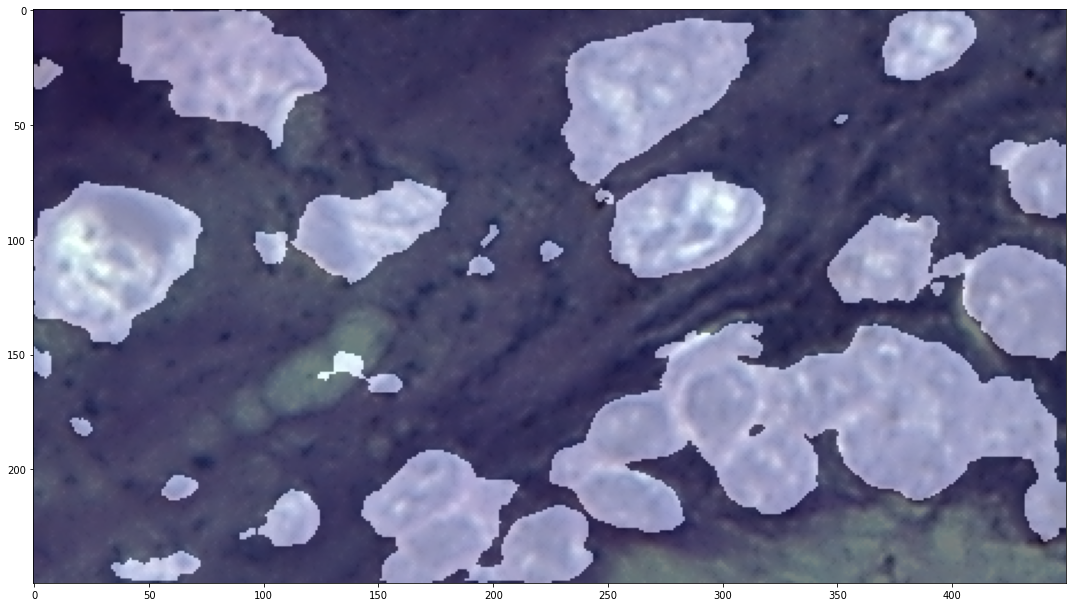

In [21]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

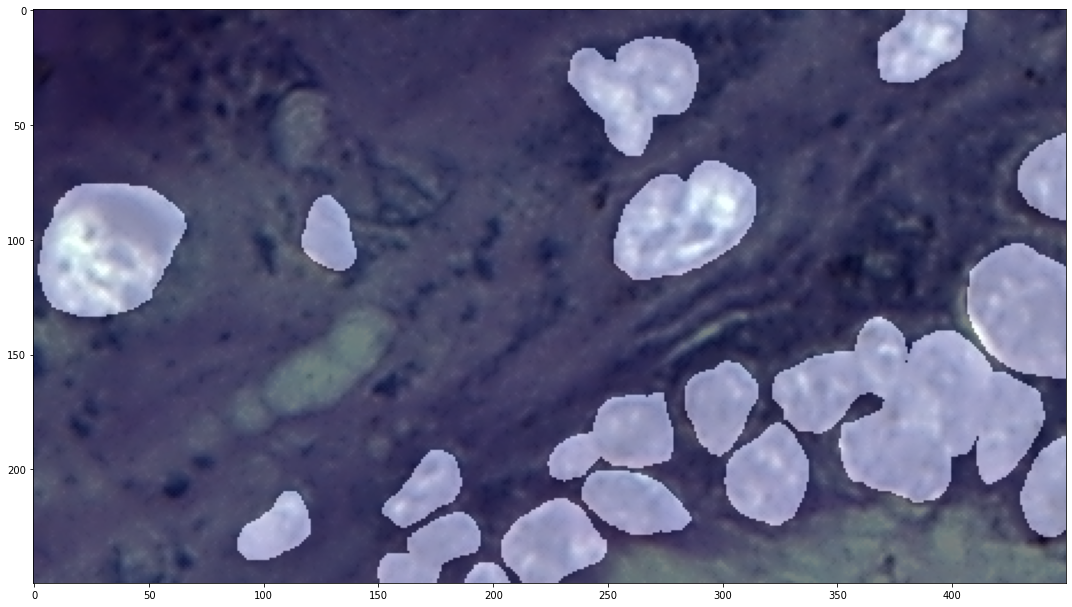

In [22]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')
result = mmcv.imread('ToTrain/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

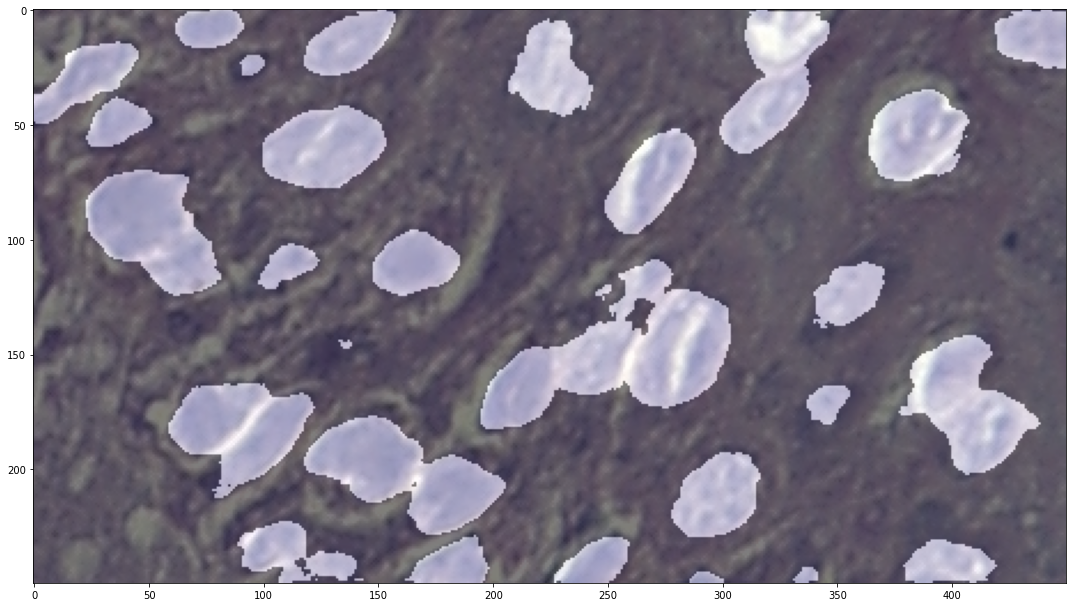

In [23]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

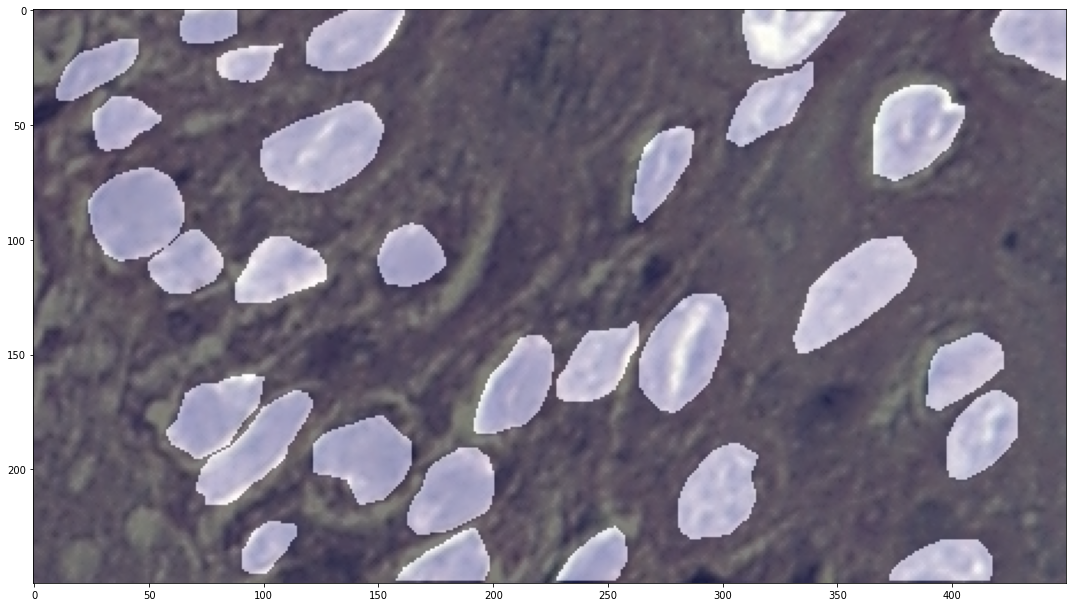

In [24]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')
result = mmcv.imread('ToTrain/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [25]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
   creating: segmentation/annotations/healthy/
  inflating: segmentation/annotations/healthy/image003-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi3.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi4.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi5.tif  
  inflating: segmentation/annotations/healthy/image004-roi1.tif  
  inflating: segmentation/annotations/healthy/image004-roi2.tif  
  inflating: segmentation/annotations/healthy/image004-roi3.tif  
  inflating: segmentation/annotations/healthy/image004-roi4.tif  
  inflating: segmentation/annotations/healthy/image004-roi5.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi1.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi3.tif  
  inflating: segmentation/annotations/healthy/im

In [26]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/unet/result/' + img_path[20:]))

In [27]:
%rm -rf ./work_dirs/unet/result/

In [28]:
%mkdir ./work_dirs/unet/result/
%mkdir ./work_dirs/unet/result/healthy
%mkdir ./work_dirs/unet/result/mild
%mkdir ./work_dirs/unet/result/moderate
%mkdir ./work_dirs/unet/result/severe

In [30]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path[:-4]}.png', predict_img)

In [31]:
%matplotlib inline
import json

file = open('./work_dirs/unet/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

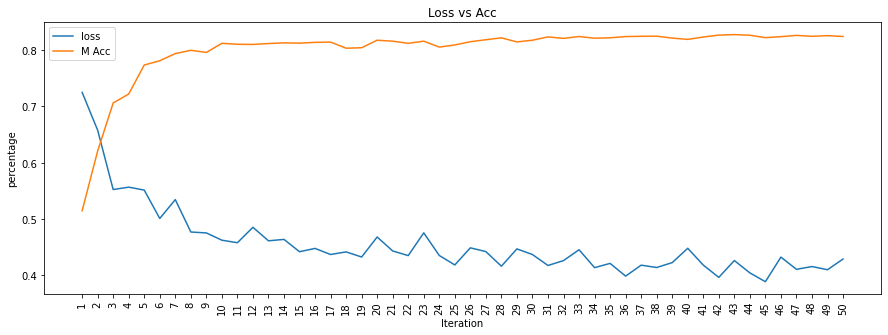

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

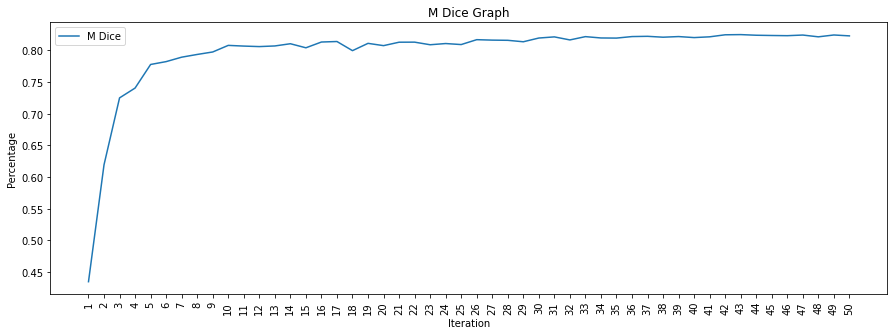

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()

In [34]:
from zipfile import ZipFile

with ZipFile('pspnet_unet.zip', 'w') as zipObj2:
  images_glob = glob('./work_dirs/unet/*')

  train_images = []
  for img_path in images_glob:
    zipObj2.write(img_path)